# Evaluación de SPASS (test dataset)

In [45]:
%load_ext autoreload 
%autoreload 2

import yaml
import json
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from fusanet_utils.datasets.fusa import FUSA_dataset
from fusanet_utils.transforms import Collate_and_transform
from fusanet_utils.datasets.simulated import SimulatedPoliphonic

eps = torch.finfo(torch.float).eps

dataset = SimulatedPoliphonic('../..', external=True, mini=False)

scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
is_scenario = lambda filename: [key for key, scene in scenarios.items() if scene in filename][0]

models_metadata = {0: {'name': 'PANN', 
                       'path': Path('../../experiments/Poliphonic-PANN-sed-no-pretrained/')},
                   1: {'name': 'HTS', 
                       'path': Path('../../experiments/Poliphonic-HTS/')},
                   2: {'name': 'SED-CRNN', 
                       'path': Path('../../experiments/Poliphonic-ADAVANNE-sed/')}
                  }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total parameters number: 79480452
Trainable parameters number: 78396996


  0%|          | 0/100 [00:00<?, ?it/s]

Total parameters number: 28771163
Trainable parameters number: 27687707


  0%|          | 0/100 [00:00<?, ?it/s]

Total parameters number: 374881
Trainable parameters number: 374881


  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
preds_soft, labels, distances, places, file_names = {}, {}, {}, {}, {}
for model_idx in [0, 1, 2]:
    experiment_path = models_metadata[model_idx]['path']
    #categories = json.load(open(str(experiment_path / 'index_to_name.json')))
    model = torch.load(str(experiment_path / 'model.pt'))
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters number: {pytorch_total_params}')
    print(f'Trainable parameters number: {pytorch_trainable_params}')
    model.eval()
    params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))
    fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), params=params)
    fusa_loader = DataLoader(fusa_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=2,
                             collate_fn=Collate_and_transform(params["features"]))
    preds_model, labels_model, distances_model, filenames_model = [], [], [], []
    with torch.no_grad():
        for sample in tqdm(fusa_loader):
            preds_model.append(model(sample).numpy())
            labels_model.append(sample['label'].numpy())
            distances_model.append(sample['distance'].numpy())
            filenames_model.append(sample['filename'])
    preds_soft[model_idx] = np.concatenate(preds_model)
    labels[model_idx] = np.concatenate(labels_model)
    distances[model_idx] = np.concatenate(distances_model)
    file_names[model_idx] = np.concatenate(filenames_model)
    places[model_idx] = np.array([is_scenario(sample[0].stem) for sample in dataset])

Total parameters number: 79480452
Trainable parameters number: 78396996


  0%|          | 0/100 [00:00<?, ?it/s]

Total parameters number: 28771163
Trainable parameters number: 27687707


  0%|          | 0/100 [00:00<?, ?it/s]

Total parameters number: 374881
Trainable parameters number: 374881


  0%|          | 0/100 [00:00<?, ?it/s]

In [76]:
path = Path('predictions/paper/analisis_1')

In [77]:
np.save(path / 'preds_soft.npy', preds_soft)
np.save(path / 'labels.npy', labels)
np.save(path / 'distances.npy', distances)
np.save(path / 'file_names.npy', file_names)
np.save(path / 'places.npy', places)

In [282]:
preds_soft = np.load(path / 'preds_soft.npy', allow_pickle=True).item()
labels = np.load(path / 'labels.npy', allow_pickle=True).item()
distances = np.load(path / 'distances.npy', allow_pickle=True).item()
file_names = np.load(path / 'file_names.npy', allow_pickle=True).item()
places = np.load(path / 'places.npy', allow_pickle=True).item()

In [283]:
ths_path = path / "thresholds"
ths_path

PosixPath('predictions/paper/analisis_1/thresholds')

In [284]:
psed_ths_pann = pd.read_csv(ths_path / 'Poliphonic-PANN-sed-no-pretrained_thresholds.txt')
psed_ths_hts = pd.read_csv(ths_path / 'Poliphonic-HTS_thresholds.txt')
psed_ths_adavanne = pd.read_csv(ths_path / 'Poliphonic-ADAVANNE-sed_thresholds.txt')

In [285]:
preds_pann = [c > psed_ths_pann.iloc[i][0] for i, c in enumerate(preds_soft[0].T)]
preds_hts = [c > psed_ths_hts.iloc[i][0] for i, c in enumerate(preds_soft[1].T)]
preds_adavanne = [c > psed_ths_adavanne.iloc[i][0] for i, c in enumerate(preds_soft[2].T)]
preds_pann = np.stack(preds_pann, axis=2).transpose(1, 0, 2)
preds_hts = np.stack(preds_hts, axis=2).transpose(1, 0, 2)
preds_adavanne = np.stack(preds_adavanne, axis=2).transpose(1, 0, 2)
preds_pann.shape, preds_hts.shape, preds_adavanne.shape

((100, 1001, 33), (100, 1024, 33), (100, 431, 33))

In [286]:
#preds = {model: preds_soft[model] >= 0.3 for model in preds_soft.keys()}
preds = {0: preds_pann, 1: preds_hts, 2: preds_adavanne}

## Por clase para todos los ambientes

In [287]:
#https://stackoverflow.com/questions/65070070/highlight-the-best-value-of-each-row-in-python-pandas-to-latex

import pandas as pd

df = []
for idx in preds.keys():
    insertions = np.sum((preds[idx] == 1) & (labels[idx] == 0), axis=(0, 1))
    deletions = np.sum((preds[idx] == 0) & (labels[idx] == 1), axis=(0, 1))
    T = np.sum((labels[idx] == 1), axis=(0, 1))
    error_rate = (insertions + deletions) / (T + eps)
    df.append(pd.Series(error_rate, index=list(dataset.categories), name=models_metadata[idx]['name']))
    
print(pd.concat(df, axis=1).to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
{} &  PANN &  HTS &  SED-CRNN \\
\midrule
Vwater            &  0.99 & 0.54 &      1.42 \\
air\_conditioner   &  0.49 & 0.54 &      0.91 \\
airborne          &  0.80 & 0.73 &      3.23 \\
alarm             &  0.34 & 0.31 &      0.96 \\
bells             &  0.27 & 0.27 &      1.00 \\
bird              &  0.28 & 0.26 &      0.36 \\
braking           &  0.53 & 0.61 &      1.00 \\
bus\_idling        &  0.33 & 0.38 &      1.21 \\
bus\_moving        &  0.41 & 0.41 &      2.62 \\
car\_idling        &  0.59 & 0.53 &      1.33 \\
car\_moving        &  0.20 & 0.11 &      0.15 \\
crowd             &  0.93 & 0.84 &      0.91 \\
cutting           &  0.82 & 0.90 &      1.74 \\
dog               &  0.32 & 0.45 &      0.98 \\
drilling          &  0.96 & 0.74 &      2.80 \\
explosives        &  1.00 & 1.39 &      1.00 \\
fireworks         &  2.21 & 1.47 &      3.08 \\
horn              &  0.61 & 0.56 &      3.51 \\
impact            &  0.29 & 0.29 &      0.59 \\
motorcycle

/tmp/ipykernel_1001754/553710008.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(df, axis=1).to_latex(float_format="%.2f"))


# Por clase

## F1-score

Text(0.5, 0, 'F1-Score')

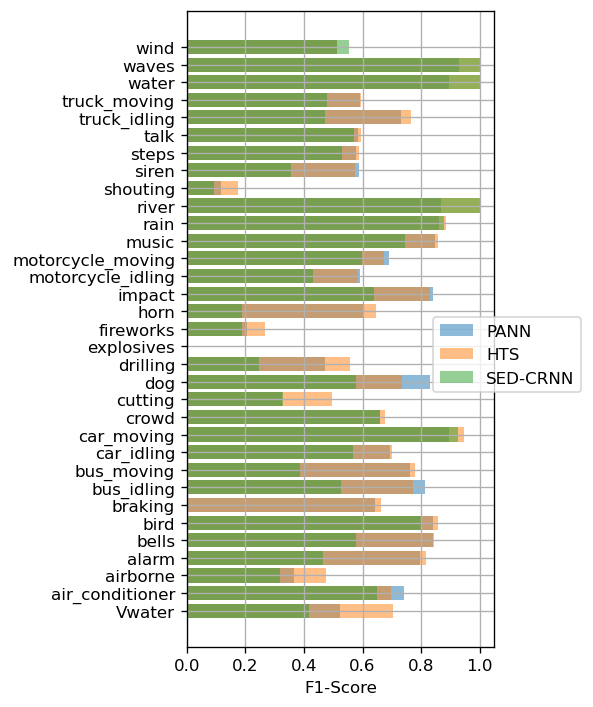

In [303]:
fig, ax = plt.subplots(figsize=(5, 6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

f1_scores = []
for idx in preds.keys():  
    TP = np.sum((preds[idx]==1) & (labels[idx]==1), axis=(0, 1))
    FP = np.sum((preds[idx]==1) & (labels[idx]==0), axis=(0, 1)) #insertions
    FN = np.sum((preds[idx]==0) & (labels[idx]==1), axis=(0, 1)) #deletions
    prec = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    f1_scores.append(f1_score)
    ax.barh(y=list(dataset.categories), width=f1_score, alpha=0.5, label=models_metadata[idx]['name'])

ax.legend(loc = (0.8, 0.4))
ax.grid()
ax.set_xlabel('F1-Score')

In [289]:
for i, f1_score in enumerate(f1_scores):
    print(models_metadata[i]['name'], f1_score.mean())
    #f1_score = f1_score[f1_score != 0.0]
    #print(models_metadata[i]['name'], f1_score.mean())

PANN 0.6435149210337162
HTS 0.6749882411853878
SED-CRNN 0.5203738237154211


# Por ambiente separado por clase:

## F1-score 

Text(0.5, 0.01, 'F1-Score')

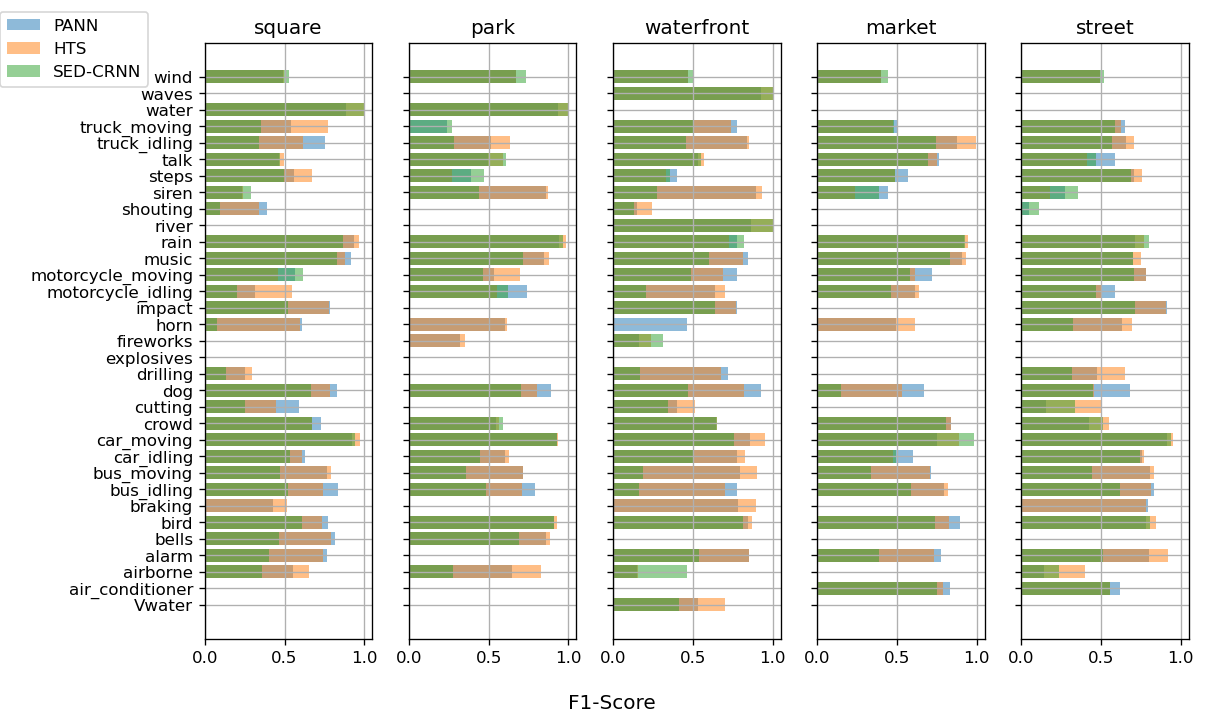

In [316]:
fig, ax = plt.subplots(1, 5, figsize=(10,  6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    TP, FP, FN = [], [], []
    for place in scenarios.keys():
        mask = places[idx] == place
        TP.append((preds[idx][mask] == 1) & (labels[idx][mask] == 1))
        FP.append((preds[idx][mask] == 1) & (labels[idx][mask] == 0))
        FN.append((preds[idx][mask] == 0) & (labels[idx][mask] == 1))
    TP = np.sum(np.stack(TP), axis=(1, 2))
    FP = np.sum(np.stack(FP), axis=(1, 2))
    FN = np.sum(np.stack(FN), axis=(1, 2))
    
    for ax_, tps, fps, fns, scene in zip(ax, TP, FP, FN, scenarios.values()):
        prec = tps / (tps + fps + eps)
        recall = tps / (tps + fns + eps)
        f1_score = 2 * prec * recall / (prec + recall + eps)
        
        ax_.barh(y=list(dataset.categories), width=f1_score, 
                 label=models_metadata[idx]['name'], alpha=0.5)
        ax_.set_title(scene)
        ax_.grid('on')
#ax.set_xlabel('F1-Score [%]')
handles, labs = ax_.get_legend_handles_labels()
fig.legend(handles, labs, loc=(0.0, 0.88))

fig.supxlabel("F1-Score")

# Por ambiente

## F1-Score

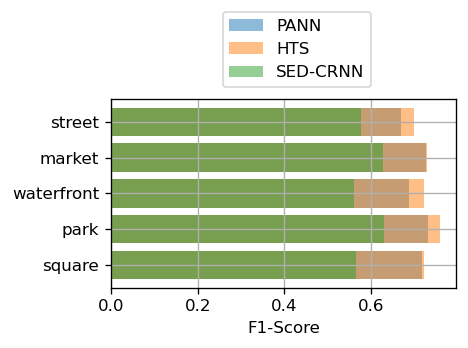

In [291]:
fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():
    TP, FP, FN = [], [], []
    for place in scenarios.keys():
        mask = places[idx] == place
        TP.append((preds[idx][mask] == 1) & (labels[idx][mask] == 1))
        FP.append((preds[idx][mask] == 1) & (labels[idx][mask] == 0))   
        FN.append((preds[idx][mask] == 0) & (labels[idx][mask] == 1))   
    TP = np.sum(np.stack(TP), axis=(1, 2, 3))
    FP = np.sum(np.stack(FP), axis=(1, 2, 3))
    FN = np.sum(np.stack(FN), axis=(1, 2, 3))
    
    prec = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    
    ax.barh(y=list(scenarios.values()), width=f1_score, 
            label=models_metadata[idx]['name'], alpha=0.5)

ax.legend(bbox_to_anchor=(0.3, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('F1-Score');

# Por macro clase

In [292]:
categories = {}
for k, category in enumerate(dataset.categories):
    categories[k] = category
inv_categories = {}
for key, values in categories.items():
    inv_categories[values] = int(key)
    
macro_classes = ['human', 'animal', 'alerts', 'music', 'environmental', 'mechanical', 'vehicle']
fusa_taxonomy = {0: ['crowd', 'shouting', 'talk', 'steps'],
                 1: ['bird', 'dog'], 
                 2: ['siren', 'bells', 'alarm', 'horn', 'braking'],
                 3: ['music'],
                 4: ['rain', 'wind', 'water', 'river', 'waves'],
                 5: ['cutting', 'drilling', 'fireworks', 
                     'impact', 'explosives', 'air_conditioner'],
                 6: ['car_idling', 'car_moving', 'bus_idling', 'bus_moving', 'airborne',
                     'motorcycle_idling', 'motorcycle_moving', 'truck_idling', 'truck_moving', 'Vwater']
                }
fusa_taxonomy_int = {}
for key, values in fusa_taxonomy.items():
    transformed_values = []
    for value in values:
        transformed_values.append(inv_categories[value])
    fusa_taxonomy_int[key] = transformed_values
        
inv_taxonomy = {}
for key, values in fusa_taxonomy_int.items():
    for value in values:
        inv_taxonomy[value] = key

## F1-Score

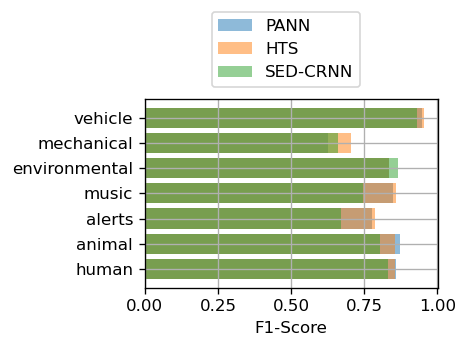

In [358]:
fig, ax = plt.subplots(figsize=(4, 3), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for idx in preds.keys():    
    pred_macro = np.stack([np.amax(preds[idx][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(macro_classes))])
    label_macro = np.stack([np.amax(labels[idx][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(macro_classes))])

    TP = np.sum((pred_macro==1) & (label_macro==1), axis=(1, 2))
    FP = np.sum((pred_macro==1) & (label_macro==0), axis=(1, 2)) #insertions
    FN = np.sum((pred_macro==0) & (label_macro==1), axis=(1, 2)) #deletions
    prec = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    
    ax.barh(y=macro_classes, width=f1_score, label=models_metadata[idx]['name'], alpha=0.5)
ax.legend(bbox_to_anchor=(0.2, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('F1-Score');

## Recall según distancia

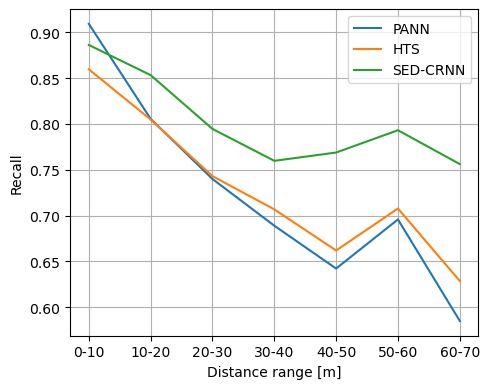

In [354]:
fig, ax = plt.subplots(figsize=(5,4),facecolor='w', tight_layout=True)
thresholds = [0, 10, 20, 30, 40, 50, 60, 70]
        
for model_idx in preds.keys():

    fn_mask = (preds[model_idx]==0) & (labels[model_idx] == 1)
    tp_mask = (preds[model_idx]==1) & (labels[model_idx] == 1)
    """
    fig, ax = plt.subplots(figsize=(6, 4), facecolor='w')

    ax.hist(distances[model_idx][deletion_mask], bins=30, alpha=0.5, density=True, 
            label='Deletions (FN)', range=(0, 100))
    ax.hist(distances[model_idx][correct_mask], bins=30, alpha=0.5, density=True, 
            label='Detections (TP)', range=(0, 100))
    ax.legend()
    ax.set_xlabel('Distance to sensor [m]')
    """
    recall = []
    for k in range(len(thresholds)-1):
        dist_mask = (distances[model_idx] > thresholds[k]) & (distances[model_idx] <= thresholds[k+1])
        FN = sum(fn_mask[dist_mask])
        TP = sum(tp_mask[dist_mask])
        r = TP / (TP + FN + eps)
        recall.append(r)

    ax.plot(thresholds[:-1], recall, label=models_metadata[model_idx]['name'])

ax.legend()
ax.grid()
ax.set_ylabel('Recall')
ax.set_xlabel('Distance range [m]')
ax.set_xticks(thresholds[:-1])
ax.set_xticklabels([f"{th1}-{th2}" for th1, th2 in zip(thresholds[:-1], thresholds[1:])]);

## Precisión según distancia

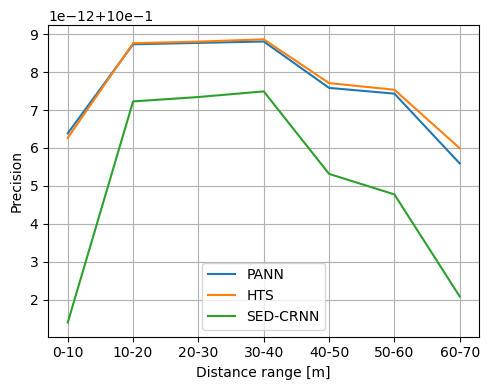

In [357]:
fig, ax = plt.subplots(figsize=(5,4),facecolor='w', tight_layout=True)
thresholds = [0, 10, 20, 30, 40, 50, 60, 70]
        
for model_idx in preds.keys():

    tp_mask = (preds[model_idx]==1) & (labels[model_idx] == 1)
    fp_mask = (preds[model_idx]==1) & (labels[model_idx] == 0)
    
    prec = []
    for k in range(len(thresholds)-1):
        dist_mask = (distances[model_idx] > thresholds[k]) & (distances[model_idx] <= thresholds[k+1])
        TP = sum(tp_mask[dist_mask])
        FP = sum(fp_mask[dist_mask])
        p = TP / (TP + FP + eps)
        prec.append(p)

    ax.plot(thresholds[:-1], prec, label=models_metadata[model_idx]['name'])

ax.legend()
ax.grid()
ax.set_ylabel('Precision')
ax.set_xlabel('Distance range [m]')
ax.set_xticks(thresholds[:-1])
ax.set_xticklabels([f"{th1}-{th2}" for th1, th2 in zip(thresholds[:-1], thresholds[1:])]);

## F1-Score según distancia

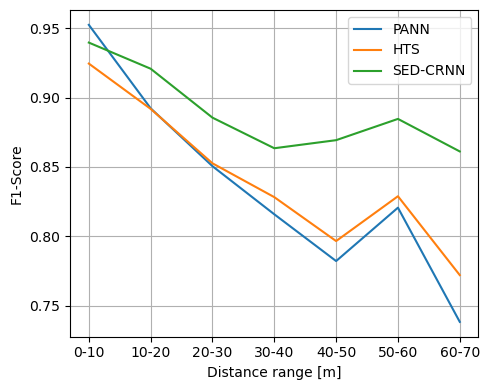

In [353]:
fig, ax = plt.subplots(figsize=(5,4),facecolor='w', tight_layout=True)
thresholds = [0, 10, 20, 30, 40, 50, 60, 70]
        
for model_idx in preds.keys():

    fn_mask = (preds[model_idx]==0) & (labels[model_idx] == 1)
    tp_mask = (preds[model_idx]==1) & (labels[model_idx] == 1)
    fp_mask = (preds[model_idx]==1) & (labels[model_idx] == 0)
    
    prec, recall, f1_score = [], [], []
    for k in range(len(thresholds)-1):
        dist_mask = (distances[model_idx] > thresholds[k]) & (distances[model_idx] <= thresholds[k+1])
        FN = sum(fn_mask[dist_mask])
        TP = sum(tp_mask[dist_mask])
        FP = sum(fp_mask[dist_mask])
        p = TP / (TP + FP + eps)
        r = TP / (TP + FN + eps)
        f1_score.append(2 * p * r / (p + r + eps))

    ax.plot(thresholds[:-1], f1_score, label=models_metadata[model_idx]['name'])

ax.legend()
ax.grid()
ax.set_ylabel('F1-Score')
ax.set_xlabel('Distance range [m]')
ax.set_xticks(thresholds[:-1])
ax.set_xticklabels([f"{th1}-{th2}" for th1, th2 in zip(thresholds[:-1], thresholds[1:])]);